# Exercise 1

Conceptual: Imagine an LLM-based agent that can either answer immediately or invoke a step-by-step reasoning chain (taking more time). Formulate a Meta-RL setup: states might include intermediate reasoning results or uncertainties, actions are “continue reasoning” or “stop and output answer”. What would a reasonable reward be? Perhaps +1 for a correct answer minus a penalty for each step used. Discuss how you would train this (maybe simulate simple math problems of varying difficulty, where continuing reasoning helps for hard ones but is wasteful for easy ones). How is this meta-level decision similar to a bandit? (Hint: each query presents a trade-off between using more resource vs. risk of being wrong, and you have to learn a policy that maps query features to an appropriate compute allocation.)

## Solution

In a meta‑reinforcement learning formulation, the agent’s state would encompass features of the current query and the partial reasoning state, such as the question’s complexity and any intermediate conclusions or uncertainty estimates generated so far. The action space consists of two discrete choices: either continue the chain-of-thought, incurring additional reasoning steps, or stop and output the current best answer. A sensible reward signal would grant a positive reward for producing a correct answer and subtract a cost proportional to the number of reasoning steps used, reflecting the compute budget. To train such a policy, one could simulate tasks of varying difficulty, where shallow reasoning suffices for easy cases but deeper reasoning is required for hard ones. By sampling many tasks, the agent learns to map problem features to appropriate compute allocation decisions, updating its policy via gradient-based reinforcement learning to maximise expected reward. This meta-level choice parallels a bandit problem: each query offers an unknown payoff distribution over compute and correctness, and the agent must learn a strategy that balances the benefit of exploring further reasoning against the risk and cost of being wrong or wasting steps.

The model could also learn not to answer, or to stop early, when a question is too difficult or effectively impossible, so it doesn’t waste tokens (e.g., trying to solve the Navier–Stokes equations).

# Exercise 2

Math/Analysis: In a risk-sensitive objective, say we want to maximize the probability of getting at least one correct solution in 3 tries (like pass@3 for coding). If the model’s per-try success probability is $p$ when optimizing for expected success, it might settle at $p=0.5$ each try (so expected 0.5, and pass@3 ~ 1 - 0.5^3 = 0.875). But a risk-seeking policy might prefer a strategy that yields $p=0.2$ on each try but occasionally a near-perfect attempt, resulting in one attempt being correct with higher probability (this is hypothetical). How would you formalize the reward for pass@3? (One way: reward = 1 if any of the 3 attempts is correct, 0 otherwise.) Why is this a non-linear, non-additive reward that standard RL would struggle with? What algorithms or approaches can handle this (hint: transform it into an auxiliary MDP or use CVaR-based optimization)?

## Solution

A practical way to model **pass@3** is as a binary (Bernoulli) outcome over a *set* of three attempts: the reward is 1 if **at least one** of the three sampled outputs is correct (e.g., passes unit tests), and 0 otherwise. If $f(x_i)\in\{0,1\}$ indicates whether the $i$-th attempt is correct, then the pass@3 objective can be written as

$$
\mathrm{Pass@3}=\mathbb{E}\left[1-\prod_{i=1}^{3}\bigl(1-f(x_i)\bigr)\right].
$$

This is exactly “one minus the probability that all three attempts fail.” The reward is **non-linear and non-additive** because it is an OR over attempts: once any attempt succeeds, additional successes do not increase reward, and the objective cannot be decomposed into a sum of per-attempt rewards without changing the problem. As a result, standard episodic RL can represent this objective (e.g., as a terminal 0/1 reward), but learning is often difficult because the signal is sparse and credit assignment across the three attempts is high-variance

One standard workaround is to re-express the problem as an **auxiliary MDP** by augmenting the environment state so the objective becomes Markov. It is helpful to separate (i) the **true state used to define the objective** from (ii) the **information available to the policy at inference**. For pass@3, a convenient true state is

$$
s_t=(t,\text{solved}),
$$

where $t\in\{0,1,2,3\}$ is the attempt index (known because the sampling procedure controls how many attempts have been generated so far) and $\text{solved}\in\{0,1\}$ means “at least one attempt so far is actually correct.” The policy chooses whether to spend compute to generate another attempt (until $t=3$) or stop; transitions update $t\leftarrow t+1$ and set $\text{solved}=1$ if the new attempt is correct, and the terminal reward is simply $\text{solved}$. This explicit augmentation preserves the Markov property because the future reward depends only on $(t,\text{solved})$.

Crucially, $\text{solved}$ is often **latent at inference** when no checker is available: it exists conceptually to define the correct objective, but it is not directly observed. The policy instead conditions on observations

$$
o_t,
$$

such as the prompt, the candidate answers generated so far, their logprobs/entropy, self-consistency statistics across samples, and optionally a learned verifier score. During training, an offline checker (unit tests, exact match, etc.) can be used to evaluate correctness and therefore compute $\text{solved}$; this ground truth is used to (a) compute the pass@3 reward and (b) train a success-probability estimator

$$
\hat p_t \approx \Pr(\text{solved}=1\mid o_t).
$$

At inference, the policy should be restricted to the same information it will actually have, typically $o_t$ and possibly the model’s own estimate $\hat p_t$, rather than conditioning on the ground-truth $\text{solved}$ flag. If a real checker is available at inference (e.g., unit tests for code), then $\text{solved}$ becomes observable and the auxiliary MDP is fully observable. If no checker is available, the setting is a **POMDP**: $t$ is explicit, $\text{solved}$ is implicit, and a belief such as $\hat p_t$ can serve as the sufficient statistic for stopping / compute allocation decisions. If a verifier is available but expensive (e.g., compilation + tests, formal checking), “invoke verifier” can be treated as an explicit action with a known cost, which reveals correctness on demand.


# Exercise 3

Coding (advanced, optional): Given two objectives, e.g., Quality and Latency, implement a simple multi-objective bandit simulation. Arm A gives high quality (reward1 ~ 0.9) at high latency (reward2 ~ -1.0 second), Arm B gives moderate quality (0.7) at low latency (-0.2). Run a bandit algorithm that tries to maximize a weighted sum of these rewards, varying the weight between quality vs. latency. Show how the chosen arm shifts as you change the weight. Then compute the Pareto-optimal set of the two arms (in this case, both might be Pareto-optimal if one is better in quality and the other in latency). Discuss how in a real system we might maintain a set of configurations (prompts/models) that lie on the Pareto frontier of (quality, cost, latency), and possibly choose among them based on real-time user preferences or contexts (for instance, a user on a slow device might implicitly prefer faster responses over slightly higher quality).

## Solution

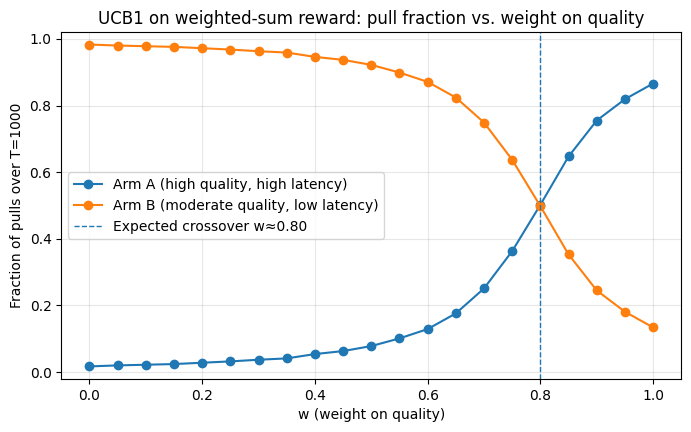

True mean objective vectors (quality, neg_latency):
- Arm A: quality=0.90, latency=1.00s (stored as -1.00)
- Arm B: quality=0.70, latency=0.20s (stored as -0.20)


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Multi-objective bandit setup --
# We use UCB1 here because its exploration bonus shrinks smoothly with uncertainty,
# which tends to produce a nice/smooth arm-selection curve vs. weight.

ARM_NAMES = ["A", "B"]
TRUE_MEANS = {
    "A": np.array([0.9, -1.0]),
    "B": np.array([0.7, -0.2]),
}
SIGMA = np.array([0.05, 0.05])  # (sigma_quality, sigma_neg_latency)


def sample_arm(arm: str, rng: np.random.Generator) -> np.ndarray:
    """Return a sample (quality, neg_latency) for an arm."""
    return rng.normal(loc=TRUE_MEANS[arm], scale=SIGMA)


def scalarize(obj: np.ndarray, w_quality: float) -> float:
    """Weighted sum scalarization: r = w*quality + (1-w)*neg_latency."""
    return float(w_quality * obj[0] + (1.0 - w_quality) * obj[1])


def ucb1_weighted_sum(w_quality: float, T: int, rng: np.random.Generator) -> np.ndarray:
    """Run UCB1 on scalarized reward, returning arm pull counts."""
    n_arms = len(ARM_NAMES)
    counts = np.zeros(n_arms, dtype=int)
    means = np.zeros(n_arms, dtype=float)

    # Pull each arm once to initialize
    for i, arm in enumerate(ARM_NAMES):
        obj = sample_arm(arm, rng)
        r = scalarize(obj, w_quality)
        counts[i] += 1
        means[i] = r

    # UCB1 loop
    for t in range(n_arms + 1, T + 1):
        ucb = means + np.sqrt(2.0 * np.log(t) / counts)
        a = int(np.argmax(ucb))
        arm = ARM_NAMES[a]

        obj = sample_arm(arm, rng)
        r = scalarize(obj, w_quality)

        counts[a] += 1
        means[a] += (r - means[a]) / counts[a]

    return counts


# --- Sweep weights and visualize how the chosen arm shifts ---
T = 1000
weights = np.linspace(0.0, 1.0, 21)
frac_A = []
frac_B = []

base_seed = 7
for w in weights:
    rng = np.random.default_rng(base_seed + int(round(w * 10_000)))
    counts = ucb1_weighted_sum(w_quality=float(w), T=T, rng=rng)
    frac_A.append(counts[0] / counts.sum())
    frac_B.append(counts[1] / counts.sum())

# Expected crossover weight from true means (where E[r_w(A)] == E[r_w(B)])
qA, lA = TRUE_MEANS["A"]
qB, lB = TRUE_MEANS["B"]
w_star = float((lB - lA) / ((qA - qB) + (lB - lA)))

plt.figure(figsize=(8, 4.5))
plt.plot(weights, frac_A, marker="o", label="Arm A (high quality, high latency)")
plt.plot(weights, frac_B, marker="o", label="Arm B (moderate quality, low latency)")
plt.axvline(w_star, linestyle="--", linewidth=1, label=f"Expected crossover w≈{w_star:.2f}")
plt.title("UCB1 on weighted-sum reward: pull fraction vs. weight on quality")
plt.xlabel("w (weight on quality)")
plt.ylabel(f"Fraction of pulls over T={T}")
plt.ylim(-0.02, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# --- Pareto-optimal set (maximize both: quality and neg-latency) ---

def dominates(x: np.ndarray, y: np.ndarray) -> bool:
    return bool(np.all(x >= y) and np.any(x > y))

arms = list(TRUE_MEANS.keys())
pareto = []
for a in arms:
    dominated = False
    for b in arms:
        if a == b:
            continue
        if dominates(TRUE_MEANS[b], TRUE_MEANS[a]):
            dominated = True
            break
    if not dominated:
        pareto.append(a)

print("True mean objective vectors (quality, neg_latency):")
for a in arms:
    q, neg_l = TRUE_MEANS[a]
    print(f"- Arm {a}: quality={q:.2f}, latency={-neg_l:.2f}s (stored as {neg_l:.2f})")


### Discussion

In a real LLM system, each “arm” is a configuration you can choose at request time (model, prompt, tool-use policy, decoding settings). Each configuration comes with trade-offs across metrics like quality, latency, and cost.

Instead of committing to one fixed weighted sum forever, you can keep the Pareto-frontier set of configs: the ones that are not strictly worse than another option on all metrics.

Then we do routing per request:
- pick the fastest/cheapest option that meets your quality bar (or SLA)
- escalate to a slower/more expensive option only when we expect a meaningful quality gain

